The goal of this notebook is to develop/understand the tools for generating an input which maximizes a particular categorical output.

We start by training a feed forward neural network on MNIST images...

In [137]:
# ------- Imports -----------

import numpy as np
from numpy import random as rd

import keras as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.regularizers import l1_l2
from keras.layers import Dense, Dropout, Input, Activation, Flatten 
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.datasets import mnist
from keras import backend as KB
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import copy

In [2]:
(x_train_images, y_train), (x_test_images, y_test) = mnist.load_data()

num_training_instances = x_train_images.shape[0]
num_test_instances = x_test_images.shape[0]

image_width = x_train_images.shape[1]
image_height = x_train_images.shape[2]

num_categories = 10

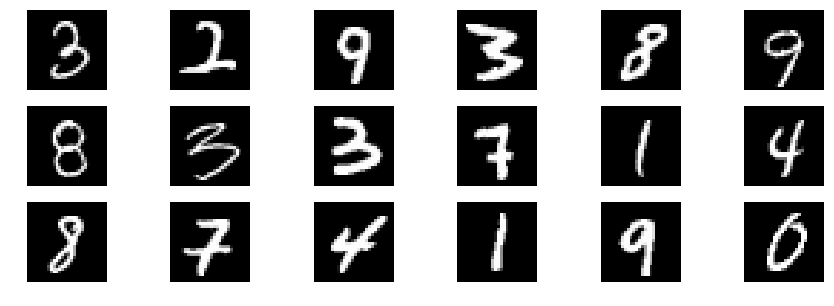

In [3]:
display_width = 6
display_height = 3
display_indices = rd.choice(num_training_instances,display_width*display_height,replace=False)

fig, axes1 = plt.subplots(display_height,display_width,figsize=(15,5))
counter = 0
for j in range(display_height):
    for k in range(display_width):
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(x_train_images[display_indices[counter],:,:], cmap = 'gray')
        counter += 1

In [4]:
num_features = image_width*image_height

x_train_vectors = np.reshape(x_train_images,[num_training_instances,num_features])/255
x_test_vectors = np.reshape(x_test_images,[num_test_instances,num_features])/255

print("Training dataset shape:", x_train_vectors.shape )
print("Test dataset shape:    ", x_test_vectors.shape )

Training dataset shape: (60000, 784)
Test dataset shape:     (10000, 784)


In [5]:
y_train_onehot = np.zeros((num_training_instances,num_categories))
y_test_onehot = np.zeros((num_test_instances,num_categories))

for j in range(num_training_instances):
    y_train_onehot[j,y_train[j]] = 1
    
for j in range(num_test_instances):
    y_test_onehot[j,y_test[j]] = 1

In [7]:
def build_ffnn(ff_layers, num_features, num_outputs, learning_rate):
    """"
    This function builds and compiles a Feed Forward Neural Network. In particular it possible to specify
    the structure of the feed forward layers arbitrarily, using the following convention:
    
      - ff_layers is a list of lists. Each inner list has the form [neurons, output_dropout]
    
    :param: num_features: the number of input features to the NN
    :param: num_categories: The length of the target label
    :param: ff_layers: A specification of the feed forward structure of the network, in the form given above.
    :param: initial_lr: The initial lr for the optimizer
    :return: nnet: The feed forward neural network, as a Keras sequential object  
    """
    
    inputs = Input(shape=(num_features,), name = "Inputs")
    
    dense_layers = []
    dropout_layers = []
    
    for j in range(len(ff_layers)):
        if j == 0:
            dropout_layers.append(Dropout(rate=ff_layers[j][1],name="dropout_on_inputs")(inputs))
        else:
            dropout_layers.append(Dropout(rate=ff_layers[j][1],name="dropout_on_dense_layer_"+str(j))(dense_layers[j-1]))
            
        dense_layers.append(Dense(units=ff_layers[j][0], 
                            activation="relu", 
                            name="dense_layer_"+str(j+1))(dropout_layers[j]))
    
    outputs = Dense(units=num_outputs, activation="softmax", name="Predictions")(dense_layers[len(dense_layers)-1])
    
    ffnn = Model(inputs=inputs, outputs=outputs)
    
    ad_opt = Adam(lr=learning_rate)
    ffnn.compile(optimizer=ad_opt,loss='categorical_crossentropy',metrics=['accuracy'])
    
    return ffnn

In [8]:
# ---- NN specification --------
learning_rate = 0.001
ff_layers = [[1000,0.1],[500,0.1],[250,0.1]]

# ------ Build the network ------
ffnn = build_ffnn(ff_layers, num_features, num_categories, learning_rate)
ffnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          (None, 784)               0         
_________________________________________________________________
dropout_on_inputs (Dropout)  (None, 784)               0         
_________________________________________________________________
dense_layer_1 (Dense)        (None, 1000)              785000    
_________________________________________________________________
dropout_on_dense_layer_1 (Dr (None, 1000)              0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 500)               500500    
_________________________________________________________________
dropout_on_dense_layer_2 (Dr (None, 500)               0         
_________________________________________________________________
dense_layer_3 (Dense)        (None, 250)               125250    
__________

In [10]:
# ------ Training Parameters -------

batch_size = 128
max_epochs = 100
validation_split = 0.15
stopping_patience = 6
lr_decay_factor = 0.2
lr_patience = 3
lr_min = 0.0001
lr_cooldown = 2

# -------- Callbacks ----------------
        
early_stopping = EarlyStopping(monitor="val_acc", mode='auto',patience=stopping_patience)

LR_schedule = ReduceLROnPlateau(monitor="val_acc", 
                                      factor=lr_decay_factor, 
                                      patience=lr_patience, 
                                      verbose=1, 
                                      mode='auto', 
                                      min_delta=0.0001, 
                                      cooldown=lr_cooldown, min_lr=lr_min)

In [11]:
training_history = ffnn.fit(x_train_vectors, y_train_onehot, batch_size=batch_size, 
                          epochs=max_epochs, verbose=1, validation_split=0.1,callbacks = [early_stopping, LR_schedule])

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 13s 245us/step - loss: 0.2468 - acc: 0.9242 - val_loss: 0.0886 - val_acc: 0.9730
Epoch 2/100
54000/54000 [==============================] - 13s 243us/step - loss: 0.1021 - acc: 0.9686 - val_loss: 0.0774 - val_acc: 0.9770
Epoch 3/100
54000/54000 [==============================] - 14s 257us/step - loss: 0.0743 - acc: 0.9761 - val_loss: 0.0760 - val_acc: 0.9763
Epoch 4/100
54000/54000 [==============================] - 14s 259us/step - loss: 0.0610 - acc: 0.9810 - val_loss: 0.0678 - val_acc: 0.9817
Epoch 5/100
54000/54000 [==============================] - 14s 251us/step - loss: 0.0509 - acc: 0.9843 - val_loss: 0.0626 - val_acc: 0.9795
Epoch 6/100
54000/54000 [==============================] - 13s 242us/step - loss: 0.0456 - acc: 0.9849 - val_loss: 0.0764 - val_acc: 0.9780
Epoch 7/100
54000/54000 [==============================] - 13s 241us/step - loss: 0.0378 - acc: 0.9876 - val_lo

Ok, great, now we want to do "gradient ascent" for categorical maximization:

In [16]:
output_index = 3

# define a placeholder for the input image_vector (the flattened image)
input_img_vec = ffnn.input

# define the loss function - which is precisely just the mean of the probability of the given character across the batch
loss = KB.mean(ffnn.output[:, output_index])

# compute the gradient of the input picture wrt this loss
grads = KB.gradients(loss, input_img_vec)[0]

# normalization trick: we normalize the gradient
grads /= (KB.sqrt(KB.mean(KB.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = KB.function([input_img_vec], [loss, grads])

In [40]:
def vec_2_im(vec):
    return np.reshape(vec,[28,28])

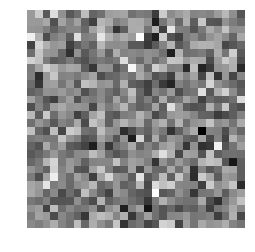

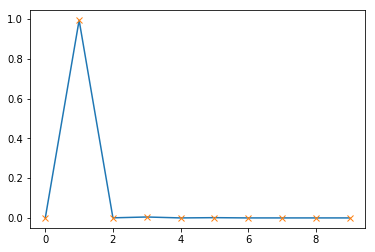

In [124]:
# we start from a gray image with some noise
input_img_data = np.random.normal(size = (784))[None]
pre_image = copy.copy(input_img_data) 

# show the image
plt.imshow(vec_2_im(input_img_data),cmap="gray")
plt.axis("off")
plt.show()

# plot the predictions of the neural net for this random image
original_preds = ffnn.predict(pre_image)
_ = plt.plot(original_preds[0,:])
_ = plt.plot(original_preds[0,:],'x')
plt.show()

In [125]:
# run gradient ascent for n steps
n = 10
step = 0.05
for i in range(n):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

    print('Current loss value:', loss_value)

Current loss value: 0.0046229525
Current loss value: 0.99770266
Current loss value: 1.0
Current loss value: 1.0
Current loss value: 1.0
Current loss value: 1.0
Current loss value: 1.0
Current loss value: 1.0
Current loss value: 1.0
Current loss value: 1.0


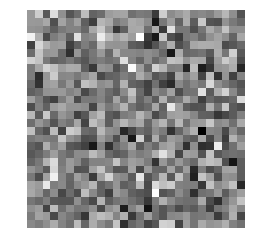

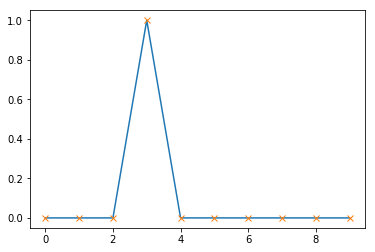

In [128]:
# plot the generated image
plt.imshow(vec_2_im(input_img_data),cmap="gray")
plt.axis("off")
plt.show()

# plot the predictions of the neural network for the generated image
new_preds = ffnn.predict(input_img_data)
_ = plt.plot(new_preds[0,:])
_ = plt.plot(new_preds[0,:],'x')

I would like to repeat this excercise with a convolutional neural network, to see if anything changes - i.e. it would be nice if we actually managed to generate images - this may just not be possible with MNIST images (i.e. the distance between random noise images and numbers via the metric of output probability might just be too close...)

We start by building the convnet (hopefully a sequential object will also work...)

In [133]:
# We start off by specifying that our cnn is a Sequential object
cnn = Sequential()

# Add the first conv layer:
cnn.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
cnn.add(Activation('relu'))

# We also use batch normalization between conv layers - see here https://arxiv.org/abs/1502.03167
BatchNormalization(axis=-1)

# Another conv layer
cnn.add(Conv2D(32, (3, 3)))
cnn.add(Activation('relu'))

# Max Pooling (Coarse Graining)
cnn.add(MaxPooling2D(pool_size=(2,2)))

# etc...
BatchNormalization(axis=-1)
cnn.add(Conv2D(64,(3, 3)))
cnn.add(Activation('relu'))
BatchNormalization(axis=-1)
cnn.add(Conv2D(64, (3, 3)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

# Finally, we flatten the output of the last conv layer, so that it can be fed into fully connected layers...
cnn.add(Flatten())

# Fully connected layers - a FFNN on top of the conv layers
BatchNormalization()
cnn.add(Dense(512))
cnn.add(Activation('relu'))
BatchNormalization()
cnn.add(Dropout(0.2))
cnn.add(Dense(10))

# We use a softmax as the final activation (ensures a legitimate probability distribution)
cnn.add(Activation('softmax'))

In [139]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_2 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_4 (Activation)    (None, 10, 10, 64)        0         
__________

In [135]:
# data processing...
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train/=255
X_test/=255

X_train.shape

(60000, 28, 28, 1)

In [138]:
number_of_classes = 10

Y_train = np_utils.to_categorical(y_train, number_of_classes)
Y_test = np_utils.to_categorical(y_test, number_of_classes)

y_train[0], Y_train[0]

(5, array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32))

In [140]:
cnn.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [141]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

train_generator = gen.flow(X_train, Y_train, batch_size=64)
test_generator = test_gen.flow(X_test, Y_test, batch_size=64)

In [142]:
cnn.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=5, 
                    validation_data=test_generator, validation_steps=10000//64)

Epoch 1/5
937/937 [==============================] - 100s 107ms/step - loss: 0.1992 - acc: 0.9364 - val_loss: 0.0305 - val_acc: 0.9891
Epoch 2/5
937/937 [==============================] - 101s 108ms/step - loss: 0.0642 - acc: 0.9806 - val_loss: 0.0451 - val_acc: 0.9860
Epoch 3/5
937/937 [==============================] - 104s 111ms/step - loss: 0.0497 - acc: 0.9850 - val_loss: 0.0285 - val_acc: 0.9912
Epoch 4/5
937/937 [==============================] - 102s 109ms/step - loss: 0.0412 - acc: 0.9877 - val_loss: 0.0276 - val_acc: 0.9916
Epoch 5/5
937/937 [==============================] - 103s 110ms/step - loss: 0.0382 - acc: 0.9884 - val_loss: 0.0204 - val_acc: 0.9938


In [144]:
output_index = 3

# define a placeholder for the input image_vector (the flattened image)
input_image = cnn.input

# define the loss function - which is precisely just the mean of the probability of the given character across the batch
cnn_loss = KB.mean(cnn.output[:, output_index])

# compute the gradient of the input picture wrt this loss
cnn_grads = KB.gradients(cnn_loss, input_image)[0]

# normalization trick: we normalize the gradient
cnn_grads /= (KB.sqrt(KB.mean(KB.square(cnn_grads))) + 1e-5)

# this function returns the loss and grads given the input picture
cnn_iterate = KB.function([input_image], [cnn_loss, cnn_grads])

In [154]:
def batched_image(image):
    return np.reshape(image[None],[1,28,28,1])

def normal_image(batched_image):
    return batched_image[0,:,:,0]

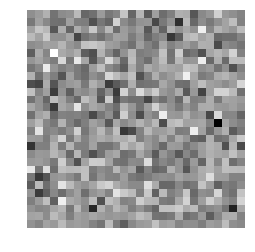

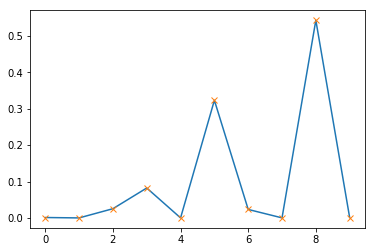

In [158]:
# we start from a gray image with some noise
input_img_data = np.random.normal(size = (28,28))
input_img_data = batched_image(input_img_data)
pre_image = copy.copy(input_img_data) 

# show the image
plt.imshow(normal_image(input_img_data),cmap="gray")
plt.axis("off")
plt.show()

# plot the predictions of the neural net for this random image
original_preds = cnn.predict(pre_image)
_ = plt.plot(original_preds[0,:])
_ = plt.plot(original_preds[0,:],'x')
plt.show()

In [159]:
# run gradient ascent for n steps
n = 10
step = 0.05
for i in range(n):
    loss_value, grads_value = cnn_iterate([input_img_data])
    input_img_data += grads_value * step

    print('Current loss value:', loss_value)

Current loss value: 0.082244374
Current loss value: 0.9640003
Current loss value: 0.9999596
Current loss value: 0.9999969
Current loss value: 0.99999785
Current loss value: 0.9999982
Current loss value: 0.99999857
Current loss value: 0.9999988
Current loss value: 0.9999989
Current loss value: 0.99999905


In [ ]:
# we start from a gray image with some noise
input_img_data = np.random.normal(size = (28,28))
input_img_data = batched_image(input_img_data)
pre_image = copy.copy(input_img_data) 

# show the image
plt.imshow(normal_image(input_img_data),cmap="gray")
plt.axis("off")
plt.show()

# plot the predictions of the neural net for this random image
original_preds = cnn.predict(pre_image)
_ = plt.plot(original_preds[0,:])
_ = plt.plot(original_preds[0,:],'x')
plt.show()